In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import os
import h5py
import numpy
import pandas as pd
import pylab as plt
from bilby.core.prior import MultivariateGaussian, MultivariateGaussianDist, PriorDict
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pycbc.conversions as convert
import bilby
import pycbc
import seaborn as sns

## Load FM errors and covariance matrices

In [2]:
def decode_data(data):
    """
    Decodes byte strings or arrays of byte strings from HDF5.
    """
    if isinstance(data, bytes):
        return data.decode('utf-8')
    elif isinstance(data, np.ndarray) and data.dtype.kind in {'S', 'O'}:
        return [d.decode('utf-8') if isinstance(d, bytes) else d for d in data]
    else:
        return data

def load_from_h5_group(group):
    """
    Recursively loads data from an HDF5 group and reconstructs Python objects.
    """
    result = {}

    # Check if this group is an array-style list (all keys are numeric)
    keys = list(group.keys())
    if all(k.isdigit() for k in keys):
        # Treat it as a list, sorted by numeric key
        items = []
        for key in sorted(keys, key=lambda x: int(x)):
            val = group[key]
            if isinstance(val, h5py.Group):
                items.append(load_from_h5_group(val))
            else:
                items.append(decode_data(val[()]))
        return items

    # Otherwise treat as dict
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_from_h5_group(item)
        else:
            result[key] = decode_data(item[()])

    return result

def load_results_from_h5(filename):
    """
    Loads structured data from a universally saved HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        return load_from_h5_group(f)

In [3]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
mass_band = 'below_40'
#mass_band = '40-80'
#mass_band = 'above_80'
#file_str = f'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_pop_from_XPHM_det10_{mass_band}'
file_str = f'LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_365_days_pop_from_XPHM_det10_{mass_band}'
fm_err_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors', 'mass_bands',
                           f'{file_str}.h5')
#fm_err_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH', 
#                           'LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_pop_from_XPHM.h5')

In [4]:
with h5py.File(fm_err_file, 'r') as f:
    print(f['all_inj_params_original'].keys())
    #print(f['all_inj_params_original']['0']['q'][()])

<KeysViewHDF5 ['PSD_H1', 'PSD_I1', 'PSD_L1', 'SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_H1', 'SNR_mf_I1', 'SNR_mf_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'inv_q', 'log_distance', 'mass1', 'mass2', 'mchirp', 'mtotal', 'old_index', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn', 'time_interval', 'trigger_time']>


In [5]:
fm_results = load_results_from_h5(fm_err_file)

In [6]:
num_events = len(fm_results['errors']['chirp_mass'])
num_events

3357

In [7]:
for key,val in fm_results.items():
    if type(val) == dict:
        fm_results[key] = pd.DataFrame(fm_results[key])

In [8]:
for key in fm_results['all_inj_params_original'].keys():
    if 'PSD' in key or 'approximant' in key:
        del fm_results['all_inj_params_original'][key]

## Convert DL to logDL cov matrix

In [9]:
def transform_cov_DL_Mc_to_logDL_logMc(cov, DL, DL_index, Mc, Mc_index):
    """
    Transforms a covariance matrix where:
    - DL is replaced with log_DL using dlogDL/dDL = 1/DL
    - Mc is replaced with log_Mc using dlogMc/dMc = 1/Mc
    - Other parameters remain unchanged

    Parameters:
    -----------
    cov : np.ndarray
        Original NxN covariance matrix including DL and Mc.
    DL : float
        Mean value of DL (Mpc).
    DL_index : int
        Index of DL in the covariance matrix.
    Mc : float
        Mean value of chirp mass (solar masses).
    Mc_index : int
        Index of Mc in the covariance matrix.

    Returns:
    --------
    cov_new : np.ndarray
        Transformed covariance matrix with log_DL and log_Mc replacing DL and Mc.
    """

    # Derivatives for Jacobian
    dlogDL_dDL = 1.0 / DL
    dlogMc_dMc = 1.0 / Mc

    # Build Jacobian matrix
    N = cov.shape[0]
    J = np.eye(N)
    J[DL_index, DL_index] = dlogDL_dDL
    J[Mc_index, Mc_index] = dlogMc_dMc

    # Transform covariance matrix
    cov_new = J @ cov @ J.T

    return cov_new

### Convert cov matrices to new cov matrices

In [10]:
DL_idx = fm_results['deriv_variables_in_order'].index('luminosity_distance')
Mc_idx = fm_results['deriv_variables_in_order'].index('chirp_mass')
fm_results['new_cov'] = []
for i in range(len(fm_results['cov'])):
    new_cov = transform_cov_DL_Mc_to_logDL_logMc(fm_results['cov'][i],
                                                 fm_results['inj_params']['luminosity_distance'][i], DL_idx, 
                                                 fm_results['inj_params']['chirp_mass'][i], Mc_idx)
    fm_results['new_cov'].append(new_cov)
fm_results['new_cov'] = np.array(fm_results['new_cov'])
fm_results['new_deriv_variables_in_order'] = []

for var in fm_results['deriv_variables_in_order']:
    if var == 'luminosity_distance' or var == 'chirp_mass':
        fm_results['new_deriv_variables_in_order'].append(f'log_{var}')
    else:
        fm_results['new_deriv_variables_in_order'].append(var)

In [11]:
fm_results['new_deriv_variables_in_order']

['log_chirp_mass',
 'mass_ratio',
 'log_luminosity_distance',
 'theta_jn',
 'phase',
 'geocent_time',
 'ra',
 'dec',
 'psi']

### Sanity check the errors are consistent

In [12]:
fm_results['errors']['log_luminosity_distance'] = fm_results['errors']['luminosity_distance']/fm_results['all_inj_params_original']['distance']
log_DL_idx = list(fm_results['new_deriv_variables_in_order']).index('log_luminosity_distance')

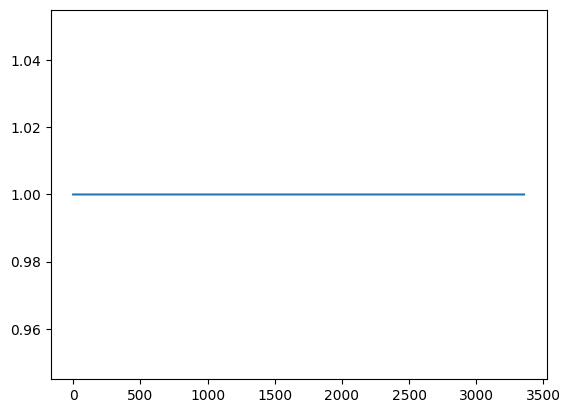

In [13]:
plt.plot([np.sqrt(cov[log_DL_idx, log_DL_idx]) for cov in fm_results['new_cov']]/fm_results['errors']['log_luminosity_distance'])

## Create new means

In [14]:
fm_results['deriv_variables_in_order']

['chirp_mass',
 'mass_ratio',
 'luminosity_distance',
 'theta_jn',
 'phase',
 'geocent_time',
 'ra',
 'dec',
 'psi']

In [15]:
param_bounds = {
    'chirp_mass':[1, np.inf],
    'log_chirp_mass':[0, np.inf],
    'mass_ratio':[1/20, 1],
    'luminosity_distance':[1, np.inf],
    'log_luminosity_distance':[0, np.inf],
    'theta_jn':[0, np.pi],
    'geocent_time':[-np.inf, np.inf],
    'ra':[0, 2*np.pi],
    'dec':[-np.pi/2, np.pi/2],
    'psi':[0, 2*np.pi]
}

if max(fm_results['all_inj_params_original']['coa_phase']) > np.pi:
    param_bounds['phase'] = [0, 2*np.pi]
else:    
    param_bounds['phase'] = [-np.pi, np.pi]

In [16]:
param_bounds

{'chirp_mass': [1, inf],
 'log_chirp_mass': [0, inf],
 'mass_ratio': [0.05, 1],
 'luminosity_distance': [1, inf],
 'log_luminosity_distance': [0, inf],
 'theta_jn': [0, 3.141592653589793],
 'geocent_time': [-inf, inf],
 'ra': [0, 6.283185307179586],
 'dec': [-1.5707963267948966, 1.5707963267948966],
 'psi': [0, 6.283185307179586],
 'phase': [0, 6.283185307179586]}

### Create posterior using jittered mean values for each parameter

In order to induce noise in the posterior, the following steps are followed:
1. Multivariate gaussian (MVG) is created taking true value as mean
2. One random sample is drawn for each parameter from the MVG. This sample becomes the new mean mimicking the effect of gaussian noise.
3. New gaussian is created taking the above value as the new mean

#### Using transformed cov matrices

In [17]:
fm_results['new_deriv_variables_in_order']

['log_chirp_mass',
 'mass_ratio',
 'log_luminosity_distance',
 'theta_jn',
 'phase',
 'geocent_time',
 'ra',
 'dec',
 'psi']

In [18]:
fm_results['inj_params'].loc[:, 'log_luminosity_distance'] = np.log(fm_results['inj_params']['luminosity_distance'])
fm_results['inj_params'].loc[:, 'log_chirp_mass'] = np.log(fm_results['inj_params']['chirp_mass'])

### Check if cov matrices are positive-definite

In [19]:
failed = []
for event in range(len(fm_results['all_inj_params_original'])):
    cov = fm_results['new_cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [20]:
failed

[]

### Get new means

In [21]:
n_events = len(fm_results['new_cov'])
fm_results_updated = {'new_mean_vals': []}
for key, val in fm_results.items():
    if 'variables' in key or 'new_mean' in key:
        continue
    elif isinstance(val, np.ndarray):
        fm_results_updated[key] = []
    elif isinstance(val, pd.DataFrame):
        fm_results_updated[key] = pd.DataFrame(columns=val.columns)

In [22]:
[(key, type(fm_results_updated[key])) for key in fm_results_updated.keys()]

[('new_mean_vals', list),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('cov', list),
 ('errors', pandas.core.frame.DataFrame),
 ('inj_params', pandas.core.frame.DataFrame),
 ('netw_snrs', list),
 ('sky_locs', list),
 ('new_cov', list)]

In [23]:
from numpy.linalg import LinAlgError
import logging

logging.getLogger('bilby').setLevel(logging.ERROR)
failed_convert_posteriors = []

for event in tqdm(range(n_events)):
    mu = [fm_results['inj_params'][param][event] for param in fm_results['new_deriv_variables_in_order']]
    cov = fm_results['new_cov'][event]

    # Symmetrize covariance
    cov = (cov + cov.T) / 2

    # Try constructing the posterior, adding jitter if needed
    for attempt in range(5):
        try:
            mvg = MultivariateGaussianDist(
                fm_results['new_deriv_variables_in_order'],
                mus=mu,
                covs=cov,
                bounds=[param_bounds[param] for param in fm_results['new_deriv_variables_in_order']]
            )
            break
        except LinAlgError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])
        except ValueError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])
    else:
        failed_convert_posteriors.append(event)
        continue  # skip this event

    # Sample new mean values
    new_mean_vals = {param: MultivariateGaussian(mvg, param).sample() 
                     for param in fm_results['new_deriv_variables_in_order']}
    fm_results_updated['new_mean_vals'].append(new_mean_vals)
    for key in fm_results_updated.keys():
        if key == 'new_mean_vals':
            continue
        else:
            if isinstance(fm_results_updated[key], pd.DataFrame):
                fm_results_updated[key].loc[event] = fm_results[key].loc[event]
            elif isinstance(fm_results_updated[key], list):
                fm_results_updated[key].append(fm_results[key][event])

if failed_convert_posteriors:
    print(f"Failed to convert events: {failed_convert_posteriors}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3357/3357 [00:22<00:00, 146.69it/s]

Failed to convert events: [247, 393, 2518, 2539, 2852, 3045]


In [24]:
fm_results_updated['all_inj_params_original'].reset_index(inplace=True, drop=True)
fm_results_updated['inj_params'].reset_index(inplace=True, drop=True)
fm_results_updated['errors'].reset_index(inplace=True, drop=True)
fm_results_updated['new_mean_vals'] = pd.DataFrame(fm_results_updated['new_mean_vals'])

In [25]:
[len(fm_results_updated[key]) for key in fm_results_updated.keys()]

[3351, 3351, 3351, 3351, 3351, 3351, 3351, 3351]

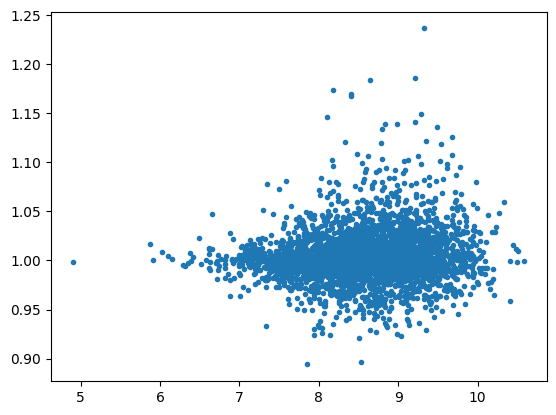

In [26]:
plt.plot(fm_results_updated['inj_params']['log_luminosity_distance'], 
         fm_results_updated['inj_params']['log_luminosity_distance']/fm_results_updated['new_mean_vals']['log_luminosity_distance'], 
         '.');

#### Save new means to h5

In [27]:
def save_to_h5_group(group, data, string_dtype, key=None):
    # if key is given, create dataset/group under that name
    if isinstance(data, dict):
        subgroup = group if key is None else group.create_group(str(key))
        for k, v in data.items():
            save_to_h5_group(subgroup, v, string_dtype, k)

    elif isinstance(data, (list, tuple)):
        subgroup = group if key is None else group.create_group(str(key))
        for i, item in enumerate(data):
            save_to_h5_group(subgroup, item, string_dtype, str(i))

    elif isinstance(data, pd.DataFrame):
        subgroup = group if key is None else group.create_group(str(key))
        for col in data.columns:
            subgroup.create_dataset(str(col), data=data[col].to_numpy())

    elif isinstance(data, str):
        if key is None:
            raise ValueError("Strings must be stored with a key")
        group.create_dataset(str(key), data=data, dtype=string_dtype)

    else:
        if key is None:
            raise ValueError("Scalars/arrays must be stored with a key")
        group.create_dataset(str(key), data=np.array(data))


def save_results_to_h5(results, filename):
    dt = h5py.string_dtype(encoding='utf-8')
    with h5py.File(filename, 'w') as f:
        save_to_h5_group(f, results, dt)

In [28]:
fm_err_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_365_days_pop_from_XPHM_det10_below_40.h5'

In [29]:
num_events

3357

In [30]:
new_fm_file = fm_err_file.replace('.h5', '_with_new_means2.h5').replace(str(num_events), str(len(fm_results_updated['new_mean_vals'])))
new_fm_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_365_days_pop_from_XPHM_det10_below_40_with_new_means2.h5'

In [31]:
save_results_to_h5(fm_results, new_fm_file)

## Calculate SNRs with new means for samples with SNR <=15

In [32]:
fm_results_updated['netw_snrs'] = np.array(fm_results_updated['netw_snrs'])

In [33]:
snr_mask_below_15 = (fm_results_updated['netw_snrs']<=15)
snr_mask_above_15 = (fm_results_updated['netw_snrs']>15)

In [34]:
len(fm_results_updated['netw_snrs'][snr_mask_below_15])

2120

In [35]:
len(fm_results_updated['netw_snrs'][snr_mask_above_15])

1231

In [36]:
fm_results_snr_below_15 = {}
fm_results_snr_above_15 = {}
for key, val in fm_results_updated.items():
    if type(val) == list:
        fm_results_snr_below_15[key] = np.array(val)[snr_mask_below_15]
        fm_results_snr_above_15[key] = np.array(val)[snr_mask_above_15]
    else:
        fm_results_snr_below_15[key] = val[snr_mask_below_15]
        fm_results_snr_above_15[key] = val[snr_mask_above_15]
    if isinstance(val, pd.DataFrame):
        fm_results_snr_below_15[key].reset_index(inplace=True)
        fm_results_snr_above_15[key].reset_index(inplace=True)

In [37]:
fm_results_snr_below_15['all_inj_params_original']

,index,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,SNR_mf_from_opt_I1,SNR_mf_from_opt_L1,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,0,5.737929,6.612176,4.515110,4.990872,5.949039,5.529881,6.329655,7.729607,5.252206,...,0.141844,0.044275,-0.066039,10.461559,6.814191,7.316764,17.275750,2.565574,499.605743,1.918683e+09
1,1,6.459393,5.967921,5.250371,7.343760,7.935865,5.183641,6.766340,4.897668,5.541406,...,-0.219477,-0.041962,-0.015915,8.392924,6.371731,6.354154,14.764655,2.348911,2222.426320,1.912483e+09
2,4,9.460108,5.742980,9.847214,11.405794,5.933732,9.773517,10.853944,5.013345,9.761409,...,0.081307,-0.623728,-0.291770,12.197304,11.636990,10.371038,23.834293,0.604727,136.362457,1.921417e+09
3,6,5.278256,7.080621,6.633048,6.181388,8.048833,8.091454,4.517418,7.742652,5.729139,...,0.565660,-0.058539,-0.494145,17.334173,13.128419,13.107382,30.462592,2.096383,306.539350,1.923731e+09
4,8,5.325550,3.977372,6.024175,5.097116,5.051174,4.908736,6.720365,3.730393,7.760278,...,-0.076987,-0.656426,-0.736565,14.806252,9.237804,10.125274,24.044057,1.067849,382.309356,1.897278e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,3343,5.905949,6.979376,7.574776,5.456311,6.720567,7.599031,6.090053,6.944513,7.816984,...,0.472832,0.058221,0.014888,9.758681,5.246928,6.170595,15.005609,0.741537,830.011452,1.915111e+09
2116,3345,8.592440,4.867569,7.473803,8.146766,5.283918,8.286178,8.338752,4.711078,6.529891,...,-0.621032,-0.300933,0.662416,13.628962,12.299460,11.268188,25.928422,1.142771,615.691024,1.924069e+09
2117,3347,7.838168,6.573160,9.460761,8.998243,7.080569,8.701748,5.769288,6.443492,9.583304,...,-0.064918,-0.054183,-0.002100,12.154861,11.041748,10.082955,23.196610,1.574023,2157.280003,1.924090e+09
2118,3348,7.498994,7.583466,9.386317,6.598482,7.896857,10.782910,9.419448,6.933749,7.506449,...,-0.282208,-0.290758,0.602100,8.334860,3.432170,4.568218,11.767029,2.002046,727.310107,1.920927e+09


In [38]:
fm_results_snr_below_15['new_mean_vals']

,index,log_chirp_mass,mass_ratio,log_luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0,2.701218,0.677748,9.090233,2.775175,4.038126,1.918683e+09,5.855407,-0.936461,1.531920
1,1,2.404828,0.776633,8.403015,2.214088,0.828339,1.912483e+09,1.107102,-0.030422,2.769643
2,4,3.179634,0.954125,9.209640,0.572663,1.324507,1.921417e+09,0.246551,-0.691551,2.741066
3,6,3.483985,0.854898,9.486652,2.147850,4.997690,1.923731e+09,2.705237,0.140874,1.183550
4,8,3.384539,0.708692,9.925102,0.609942,1.320263,1.897278e+09,2.463022,0.468256,3.121472
...,...,...,...,...,...,...,...,...,...,...
2115,3343,2.536620,0.511932,9.008354,0.394857,0.260469,1.915111e+09,2.357018,0.189034,2.899713
2116,3345,2.956442,0.915407,8.433193,1.317902,1.139024,1.924069e+09,3.387186,-1.477554,0.592214
2117,3347,2.623998,0.936153,7.532683,1.576411,4.458816,1.924090e+09,4.121815,-0.000669,2.519419
2118,3348,1.887721,0.411065,8.019213,2.126426,3.303141,1.920927e+09,5.365635,0.028278,2.668460


In [39]:
pycbc_to_pesummary_map_spins = {
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl'
}
gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [40]:
fm_results['deriv_variables_in_order']

['chirp_mass',
 'mass_ratio',
 'luminosity_distance',
 'theta_jn',
 'phase',
 'geocent_time',
 'ra',
 'dec',
 'psi']

In [41]:
fm_results_snr_below_15['new_mean_vals'].loc[:,'chirp_mass'] = np.exp(fm_results_snr_below_15['new_mean_vals']['log_chirp_mass'])
fm_results_snr_below_15['new_mean_vals'].loc[:,'luminosity_distance'] = np.exp(fm_results_snr_below_15['new_mean_vals']['log_luminosity_distance'])

/tmp/ipykernel_24353/896725840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fm_results_snr_below_15['new_mean_vals'].loc[:,'chirp_mass'] = np.exp(fm_results_snr_below_15['new_mean_vals']['log_chirp_mass'])
/tmp/ipykernel_24353/896725840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fm_results_snr_below_15['new_mean_vals'].loc[:,'luminosity_distance'] = np.exp(fm_results_snr_below_15['new_mean_vals']['log_luminosity_distance'])


In [42]:
fm_results_snr_below_15['new_mean_vals']

,index,log_chirp_mass,mass_ratio,log_luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi,chirp_mass,luminosity_distance
0,0,2.701218,0.677748,9.090233,2.775175,4.038126,1.918683e+09,5.855407,-0.936461,1.531920,14.897870,8868.256133
1,1,2.404828,0.776633,8.403015,2.214088,0.828339,1.912483e+09,1.107102,-0.030422,2.769643,11.076529,4460.495661
2,4,3.179634,0.954125,9.209640,0.572663,1.324507,1.921417e+09,0.246551,-0.691551,2.741066,24.037965,9993.003452
3,6,3.483985,0.854898,9.486652,2.147850,4.997690,1.923731e+09,2.705237,0.140874,1.183550,32.589338,13182.584940
4,8,3.384539,0.708692,9.925102,0.609942,1.320263,1.897278e+09,2.463022,0.468256,3.121472,29.504384,20436.993328
...,...,...,...,...,...,...,...,...,...,...,...,...
2115,3343,2.536620,0.511932,9.008354,0.394857,0.260469,1.915111e+09,2.357018,0.189034,2.899713,12.636882,8171.064140
2116,3345,2.956442,0.915407,8.433193,1.317902,1.139024,1.924069e+09,3.387186,-1.477554,0.592214,19.229424,4597.157606
2117,3347,2.623998,0.936153,7.532683,1.576411,4.458816,1.924090e+09,4.121815,-0.000669,2.519419,13.790745,1868.111710
2118,3348,1.887721,0.411065,8.019213,2.126426,3.303141,1.920927e+09,5.365635,0.028278,2.668460,6.604299,3038.785407


In [43]:
gwfish_input_data = {pycbc_to_pesummary_map_spins[key]:fm_results_snr_below_15['all_inj_params_original'][key] for key in pycbc_to_pesummary_map_spins.keys()}
for key in fm_results['deriv_variables_in_order']:
    gwfish_input_data[key] = fm_results_snr_below_15['new_mean_vals'][key]
gwfish_input_data = pd.DataFrame(gwfish_input_data)

In [44]:
gwfish_input_data

,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.733744,0.162607,0.806790,1.989009,1.199278,1.028160,14.897870,0.677748,8868.256133,2.775175,4.038126,1.918683e+09,5.855407,-0.936461,1.531920
1,0.776113,0.224019,2.614474,1.641900,4.989302,3.021350,11.076529,0.776633,4460.495661,2.214088,0.828339,1.912483e+09,1.107102,-0.030422,2.769643
2,0.635659,0.693381,2.332391,2.005115,3.669152,3.298349,24.037965,0.954125,9993.003452,0.572663,1.324507,1.921417e+09,0.246551,-0.691551,2.741066
3,0.892743,0.753377,1.257484,2.286180,5.520224,1.935453,32.589338,0.854898,13182.584940,2.147850,4.997690,1.923731e+09,2.705237,0.140874,1.183550
4,0.581470,0.989622,2.310148,2.410267,5.093597,4.612198,29.504384,0.708692,20436.993328,0.609942,1.320263,1.897278e+09,2.463022,0.468256,3.121472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,0.985051,0.476635,1.358079,1.539555,3.785076,0.204583,12.636882,0.511932,8171.064140,0.394857,0.260469,1.915111e+09,2.357018,0.189034,2.899713
2116,0.195548,0.956575,2.980968,0.805865,5.314391,1.086773,19.229424,0.915407,4597.157606,1.317902,1.139024,1.924069e+09,3.387186,-1.477554,0.592214
2117,0.370342,0.084585,1.370707,1.595627,3.741948,1.287067,13.790745,0.936153,1868.111710,1.576411,4.458816,1.924090e+09,4.121815,-0.000669,2.519419
2118,0.511464,0.725745,1.441895,0.592352,1.849265,2.344761,6.604299,0.411065,3038.785407,2.126426,3.303141,1.920927e+09,5.365635,0.028278,2.668460


In [45]:
import GWFish.modules as gwf_mods
import pathlib
detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
#detectors = ['CE1', 'CE2', 'ET']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 1.), config=pathlib.Path('detectors.yaml'))
fm_results_snr_below_15['new_snrs'] = pd.DataFrame()
for event in tqdm(range(len(gwfish_input_data))):
    gwfish_snr = gwf_mods.utilities.get_snr(gwfish_input_data[event:event+1], network, 
                                            'IMRPhenomXPHM', 
                                            f_ref=fm_results_snr_below_15['all_inj_params_original']['f_ref'][0])
    fm_results_snr_below_15['new_snrs'] = pd.concat([fm_results_snr_below_15['new_snrs'], gwfish_snr], ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2120/2120 [04:23<00:00,  8.06it/s]


In [46]:
fm_results_snr_below_15['new_snrs'].rename(columns={f'A_sharp_{val}':f'SNR_{key}' for key, val in gwfish_det_dict.items()}, inplace=True)
fm_results_snr_below_15['new_snrs'].rename(columns={'CE1':'SNR_C1', 'CE2':'SNR_CE20', 'ET':'SNR_ET'}, inplace=True)
fm_results_snr_below_15['new_snrs'].rename(columns={'network':'SNR_network'}, inplace=True)

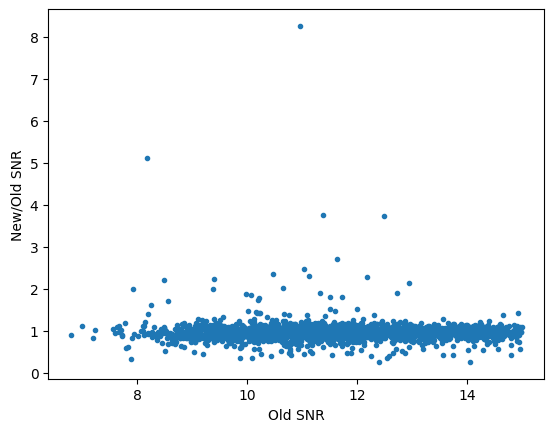

In [47]:
if len(fm_results_snr_below_15['cov']) == 0:
    print('No events with SNR <=15')
else:
    plt.plot(fm_results_snr_below_15['all_inj_params_original']['SNR_network'], 
             fm_results_snr_below_15['new_snrs']['SNR_network']/fm_results_snr_below_15['all_inj_params_original']['SNR_network'], 
             '.')
    plt.xlabel('Old SNR')
    plt.ylabel('New/Old SNR')

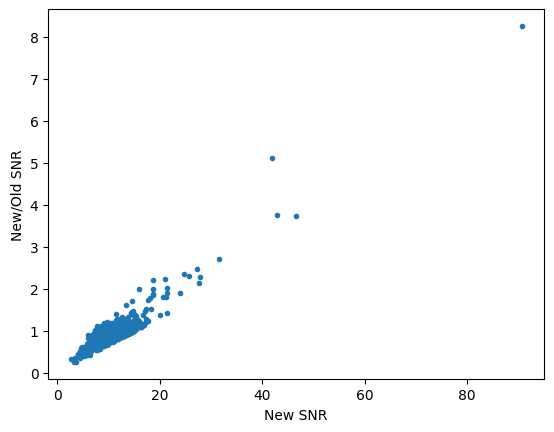

In [48]:
if len(fm_results_snr_below_15['cov']) == 0:
    print('No events with SNR <=15')
else:
    plt.plot(fm_results_snr_below_15['new_snrs']['SNR_network'], 
             fm_results_snr_below_15['new_snrs']['SNR_network']/fm_results_snr_below_15['all_inj_params_original']['SNR_network'], 
             '.')
    plt.xlabel('New SNR')
    plt.ylabel('New/Old SNR')

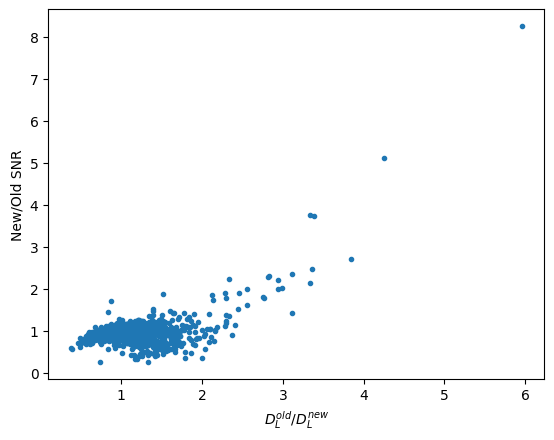

In [49]:
if len(fm_results_snr_below_15['cov']) == 0:
    print('No events with SNR <=15')
else:
    plt.plot(fm_results_snr_below_15['inj_params']['luminosity_distance']/fm_results_snr_below_15['new_mean_vals']['luminosity_distance'], 
             fm_results_snr_below_15['new_snrs']['SNR_network']/fm_results_snr_below_15['all_inj_params_original']['SNR_network'], 
             '.')
    plt.xlabel('$D_L^{old} / D_L^{new}$')
    plt.ylabel('New/Old SNR')

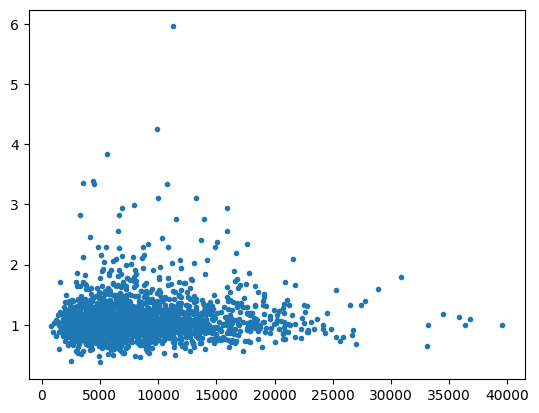

In [50]:
plt.plot(fm_results_snr_below_15['inj_params']['luminosity_distance'], 
         fm_results_snr_below_15['inj_params']['luminosity_distance']/fm_results_snr_below_15['new_mean_vals']['luminosity_distance'], 
         '.');

### Check the SNR code sanity

In [60]:
test_gwfish_input_data = {pycbc_to_pesummary_map_spins[key]:fm_results_snr_below_15['all_inj_params_original'][key] for key in pycbc_to_pesummary_map_spins.keys()}
for key in fm_results['deriv_variables_in_order']:
    test_gwfish_input_data[key] = fm_results_snr_below_15['inj_params'][key]
test_gwfish_input_data = pd.DataFrame(test_gwfish_input_data)

In [61]:
test_gwfish_input_data

,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.733744,0.162607,0.806790,1.989009,1.199278,1.028160,14.903814,0.651355,7102.476949,2.565574,5.043973,1.918683e+09,5.979558,-0.782326,1.868698
1,0.776113,0.224019,2.614474,1.641900,4.989302,3.021350,11.075118,0.759179,4714.683541,2.348911,1.723476,1.912483e+09,1.100764,-0.053062,2.967122
2,0.635659,0.693381,2.332391,2.005115,3.669152,3.298349,24.037935,0.954062,9546.153230,0.604727,0.769342,1.921417e+09,0.228548,-0.682888,3.084111
3,0.892743,0.753377,1.257484,2.286180,5.520224,1.935453,32.588701,0.757372,11071.732285,2.096383,4.580874,1.923731e+09,2.496851,-0.076270,1.317720
4,0.581470,0.989622,2.310148,2.410267,5.093597,4.612198,29.491745,0.623912,15088.750214,1.067849,2.404491,1.897278e+09,2.476892,0.504245,2.813551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,0.985051,0.476635,1.358079,1.539555,3.785076,0.204583,12.636805,0.537668,7195.229246,0.741537,0.557675,1.915111e+09,2.345870,0.146845,2.756062
2116,0.195548,0.956575,2.980968,0.805865,5.314391,1.086773,19.225902,0.902450,4431.245707,1.142771,0.564620,1.924069e+09,3.401963,-1.518038,0.845852
2117,0.370342,0.084585,1.370707,1.595627,3.741948,1.287067,13.791372,0.908422,2028.723340,1.574023,4.461540,1.924090e+09,4.031284,-0.165029,2.507842
2118,0.511464,0.725745,1.441895,0.592352,1.849265,2.344761,6.604061,0.411785,2544.204711,2.002046,3.218352,1.920927e+09,5.392731,0.091157,2.714773


In [62]:
import GWFish.modules as gwf_mods
import pathlib
detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
#detectors = ['CE1', 'CE2', 'ET']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 1.), config=pathlib.Path('detectors.yaml'))
test_snrs = pd.DataFrame()
for event in tqdm(range(len(test_gwfish_input_data))):
    test_gwfish_snr = gwf_mods.utilities.get_snr(test_gwfish_input_data[event:event+1], network, 
                                                 'IMRPhenomXPHM', 
                                                 f_ref=fm_results_snr_below_15['all_inj_params_original']['f_ref'][0])
    test_snrs = pd.concat([test_snrs, test_gwfish_snr], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2120/2120 [04:18<00:00,  8.19it/s]


In [63]:
test_snrs.rename(columns={f'A_sharp_{val}':f'SNR_{key}' for key, val in gwfish_det_dict.items()}, inplace=True)
test_snrs.rename(columns={'CE1':'SNR_C1', 'CE2':'SNR_CE20', 'ET':'SNR_ET'}, inplace=True)
test_snrs.rename(columns={'network':'SNR_network'}, inplace=True)

Text(0, 0.5, 'New/Old SNR')

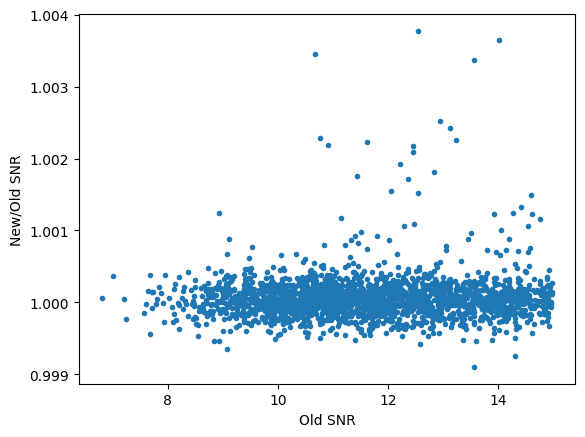

In [64]:
plt.plot(fm_results_snr_below_15['all_inj_params_original']['SNR_network'], 
         test_snrs['SNR_network']/fm_results_snr_below_15['all_inj_params_original']['SNR_network'], 
         '.')
plt.xlabel('Old SNR')
plt.ylabel('New/Old SNR')

Text(0, 0.5, 'New/Old SNR')

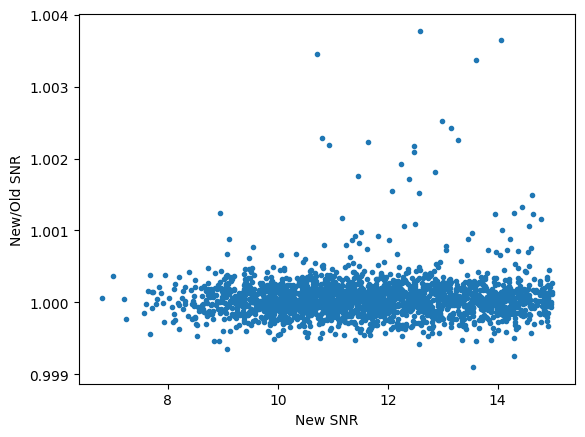

In [65]:
plt.plot(test_snrs['SNR_network'], 
         test_snrs['SNR_network']/fm_results_snr_below_15['all_inj_params_original']['SNR_network'], 
         '.')
plt.xlabel('New SNR')
plt.ylabel('New/Old SNR')

### Take points with SNR >= 12

In [51]:
if len(fm_results_snr_below_15['cov']) == 0:
    print('No events with SNR <=15')
else:
    snr_mask_above_12_new = (fm_results_snr_below_15['new_snrs']['SNR_network'] >=12)
    fm_results_snr_12_15 = {}
    for key in fm_results_updated.keys():
        val = fm_results_snr_below_15[key]
        if type(val) == list:
            fm_results_snr_12_15[key] = np.array(val)[snr_mask_above_12_new]
        else:
            fm_results_snr_12_15[key] = val[snr_mask_above_12_new]
        if isinstance(val, pd.DataFrame):
            fm_results_snr_12_15[key].reset_index(inplace=True, drop=True)

In [52]:
[(key, type(fm_results_snr_12_15[key])) for key in fm_results_snr_12_15.keys()]

[('new_mean_vals', pandas.core.frame.DataFrame),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray),
 ('errors', pandas.core.frame.DataFrame),
 ('inj_params', pandas.core.frame.DataFrame),
 ('netw_snrs', numpy.ndarray),
 ('sky_locs', numpy.ndarray),
 ('new_cov', numpy.ndarray)]

In [53]:
[(key, type(fm_results_snr_above_15[key])) for key in fm_results_snr_above_15.keys()]

[('new_mean_vals', pandas.core.frame.DataFrame),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray),
 ('errors', pandas.core.frame.DataFrame),
 ('inj_params', pandas.core.frame.DataFrame),
 ('netw_snrs', numpy.ndarray),
 ('sky_locs', numpy.ndarray),
 ('new_cov', numpy.ndarray)]

### Combine the samples SNR = (12-15) and SNR >=15

In [54]:
if len(fm_results_snr_below_15['cov']) == 0:
    print('No events with SNR <=15')
    fm_results_snr_above_12_combined_new = fm_results_snr_above_15
else:
    fm_results_snr_above_12_combined_new = {}
    for key, val in fm_results_snr_12_15.items():
        if isinstance(val, np.ndarray):
            fm_results_snr_above_12_combined_new[key] = np.concatenate((fm_results_snr_12_15[key], fm_results_snr_above_15[key]), axis=0)
        elif isinstance(val, pd.DataFrame):
            fm_results_snr_above_12_combined_new[key] = pd.concat([fm_results_snr_12_15[key], fm_results_snr_above_15[key]], axis=0, 
                                                                  ignore_index=True)

In [55]:
fm_results_snr_above_12_combined_new['all_inj_params_original']

,index,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,SNR_mf_from_opt_I1,SNR_mf_from_opt_L1,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,4,9.460108,5.742980,9.847214,11.405794,5.933732,9.773517,10.853944,5.013345,9.761409,...,0.081307,-0.623728,-0.291770,12.197304,11.636990,10.371038,23.834293,0.604727,136.362457,1.921417e+09
1,11,7.814793,6.318224,9.427966,8.334314,5.653066,9.339729,7.772256,6.404921,10.245605,...,0.504863,-0.192281,-0.201064,7.854731,3.413810,4.432501,11.268541,2.456791,957.756785,1.906833e+09
2,14,9.460114,3.748845,9.329385,8.423820,5.308567,6.673201,10.182784,1.913145,8.238195,...,-0.060585,0.048711,0.082519,15.732230,12.993089,12.435082,28.725319,1.424166,795.791322,1.907419e+09
3,20,5.613384,7.558257,6.218701,5.045447,7.621946,6.729741,5.416409,7.311148,6.011048,...,-0.002328,-0.302186,0.003966,18.644068,10.436082,12.042803,29.080150,1.472392,2099.425252,1.917996e+09
4,21,9.892610,2.575332,8.662344,9.721332,5.083268,8.055929,10.846093,3.364355,9.661198,...,0.001909,-0.005896,0.000435,10.650244,6.260210,7.058916,16.910453,2.387934,245.836682,1.908190e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3341,9.167907,15.648371,12.334877,9.576197,16.685637,13.713593,7.075897,15.258565,11.865811,...,-0.648836,-0.225883,0.697607,18.190602,11.410991,12.474962,29.601593,2.744684,36.063088,1.897947e+09
1996,3342,15.129966,6.560405,18.397225,14.987298,6.333314,19.189915,16.210412,6.159846,18.285245,...,-0.478178,0.413912,-0.024613,12.110949,9.891962,9.518759,22.002911,1.340427,88.339069,1.923107e+09
1997,3344,10.502344,8.068063,10.829235,10.565742,8.354059,10.485640,9.644713,8.294619,10.064519,...,0.358141,-0.194483,-0.307463,28.361763,9.893590,14.200833,38.255353,2.474689,697.033529,1.893502e+09
1998,3346,17.999284,10.499723,16.379522,15.501703,12.705178,15.125736,18.875933,11.138589,15.984366,...,-0.445415,0.480120,-0.159486,16.797471,15.717491,14.143589,32.514962,2.125111,501.417399,1.901352e+09


In [56]:
[len(fm_results_snr_above_12_combined_new[key]) for key in fm_results_snr_above_12_combined_new.keys()]

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]

In [57]:
[len(fm_results_snr_above_15[key]) for key in fm_results_snr_above_15.keys()]

[1231, 1231, 1231, 1231, 1231, 1231, 1231, 1231]

In [58]:
[len(fm_results_snr_12_15[key]) for key in fm_results_snr_12_15.keys()]

[769, 769, 769, 769, 769, 769, 769, 769]

### Create posteriors without parallelization

In [142]:
n_samples = 10000
n_events = len(fm_results_snr_above_12_combined_new['cov'])
params = fm_results['new_deriv_variables_in_order']
posterior_samples_all_events = {}

for event in tqdm(range(n_events)):
    mu = [fm_results_snr_above_12_combined_new['new_mean_vals'][param][event] for param in params]
    cov = fm_results_snr_above_12_combined_new['new_cov'][event]  # the covariance matrix
    mvg = MultivariateGaussianDist(params, mus=mu, covs=cov, 
                                   bounds=[param_bounds[param] for param in params])
    posterior_dists_i = dict()
    posterior_samples_i = {}
    for param in ['log_chirp_mass', 'mass_ratio', 'log_luminosity_distance']:
        posterior_dists_i[param] = MultivariateGaussian(mvg, param)
        posterior_samples_i[param] = posterior_dists_i[param].sample(n_samples)
    posterior_samples_all_events[f'event_{event}'] = posterior_samples_i

  7%|█████████▉                                                                                                                                      | 407/5882 [03:06<41:50,  2.18it/s]


KeyboardInterrupt: 

### Create posteriors with parallelization

In [59]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np
from numpy.linalg import LinAlgError


def process_event(event, data, params, param_bounds, n_samples):
    """
    Process a single event: build Gaussian dist and sample.
    Returns (event_key, samples, failed_info).
    """
    mu = [data['new_mean_vals'][param][event] for param in params]
    cov = data['new_cov'][event]  # covariance matrix

    # Symmetrize covariance
    cov = (cov + cov.T) / 2

    mvg = None
    for attempt in range(5):
        try:
            mvg = MultivariateGaussianDist(
                params, mus=mu, covs=cov,
                bounds=[param_bounds[param] for param in params]
            )
            break  # success
        except LinAlgError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])
        except ValueError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])

    if mvg is None:  # all attempts failed
        failed_info = {
            "event": event,
            "params": {p: data['new_mean_vals'][p][event] for p in params},
            "error": "LinAlgError after jitter attempts",
        }
        return f'event_{event}', None, failed_info

    # If we succeed, sample posteriors
    posterior_samples_i = {}
    for param in ['log_chirp_mass', 'mass_ratio', 'log_luminosity_distance']:
        posterior_d = MultivariateGaussian(mvg, param)
        posterior_samples_i[param] = posterior_d.sample(n_samples)

    return f'event_{event}', posterior_samples_i, None


def parallel_sampling(data, params, param_bounds, n_samples, nproc=4):
    """
    Parallel sampling across events with failure logging.
    """
    n_events = len(data['new_cov'])
    results_list = [None] * n_events
    failed_events = []

    with ProcessPoolExecutor(max_workers=nproc) as executor:
        futures = {
            executor.submit(process_event, event, data, params, param_bounds, n_samples): event
            for event in range(n_events)
        }

        for future in tqdm(as_completed(futures), total=n_events):
            event_key, samples, failed_info = future.result()
            idx = int(event_key.split("_")[1])
            results_list[idx] = (event_key, samples)

            if failed_info is not None:
                failed_events.append(failed_info)

    # Filter out None entries before unpacking
    posterior_samples_all_events = {
        k: v for kv in results_list if kv is not None for k, v in [kv]
    }

    return posterior_samples_all_events, failed_events

In [60]:
posterior_samples_all_events, failed_events = parallel_sampling(
    data=fm_results_snr_above_12_combined_new,
    params=fm_results['new_deriv_variables_in_order'],
    param_bounds=param_bounds,
    n_samples=10000,
    nproc=8  # adjust to number of CPU cores
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [43:50<00:00,  1.32s/it]


In [61]:
failed_events

[]

In [62]:
len(posterior_samples_all_events)

2000

##### Add Mc and DL from log_Mc and log_DL

In [63]:
posterior_samples_all_events['event_0'].keys()

dict_keys(['log_chirp_mass', 'mass_ratio', 'log_luminosity_distance'])

In [64]:
for event in posterior_samples_all_events.keys():
    posterior_samples_all_events[event]['chirp_mass'] = np.exp(posterior_samples_all_events[event]['log_chirp_mass'])
    posterior_samples_all_events[event]['luminosity_distance'] = np.exp(posterior_samples_all_events[event]['log_luminosity_distance'])

### Add m1, m2, q, z

In [65]:
for event in tqdm(posterior_samples_all_events.keys()):
    Mc = posterior_samples_all_events[event]['chirp_mass']
    q = posterior_samples_all_events[event]['mass_ratio']
    DL = posterior_samples_all_events[event]['luminosity_distance']
    posterior_samples_all_events[event]['mass_1'] = convert.mass1_from_mchirp_q(Mc, 1/q)
    posterior_samples_all_events[event]['mass_2'] = convert.mass2_from_mchirp_q(Mc, 1/q)
    posterior_samples_all_events[event]['redshift'] = pycbc.cosmology.redshift(DL, cosmology='Planck18')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 389.38it/s]


#### Add source frame parameters

In [66]:
for event in posterior_samples_all_events.keys():
    for param in ['mass_1', 'mass_2', 'chirp_mass']:
        posterior_samples_all_events[event][param+'_source'] = posterior_samples_all_events[event][param]/(1 + posterior_samples_all_events[event]['redshift'])

In [67]:
posterior_samples_all_events['event_0'].keys()

dict_keys(['log_chirp_mass', 'mass_ratio', 'log_luminosity_distance', 'chirp_mass', 'luminosity_distance', 'mass_1', 'mass_2', 'redshift', 'mass_1_source', 'mass_2_source', 'chirp_mass_source'])

### Save all posteriors to h5 file

In [68]:
len(posterior_samples_all_events)

2000

In [69]:
#events_posterior_file = os.path.join(base_dir, 'event_posterior_files', 'BBH', 'CE4020ET123', 'GWFish', 'mass_bands',
#                        f'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_posteriors_10K_{len(posterior_samples_all_events)}_events_pop_from_XPHM2_{mass_band}.h5')
events_posterior_file = os.path.join(base_dir, 'event_posterior_files', 'BBH', 'Asharp', 'GWFish', 'mass_bands',
                        f'LHI_Asharp_2_PLP_z_fref_10_MD_zmax_10_lmrd_22_no_spins_posteriors_10K_{len(posterior_samples_all_events)}_events_pop_from_XPHM2_{mass_band}.h5')
events_posterior_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/event_posterior_files/BBH/Asharp/GWFish/mass_bands/LHI_Asharp_2_PLP_z_fref_10_MD_zmax_10_lmrd_22_no_spins_posteriors_10K_2000_events_pop_from_XPHM2_below_40.h5'

In [70]:
save_results_to_h5(posterior_samples_all_events, events_posterior_file)

## Considering only redshift posterior for gwpop analysis

### Create prior on redshift

$p(z)dz = p(\log D_L) d(\log D_L)$

Since the posteriors were drawn from a Multivariate Gaussian created on $\log\mathcal{M}_c$, $q$, and $\log D_L$, the priors are uniform on these parameters.

Hence,

$p(z) = p(\log D_L) \frac{1}{D_L} \left| \frac{dD_L(z)}{dz} \right| \propto \frac{1}{D_L} \left| \frac{dD_L(z)}{dz} \right|$

since $p(log(D_L)) = const$

In [71]:
def calc_dDL_dz(DL_arr, z_arr):
    """
    Parameters: 
    ----------------------
    z_arr: numpy array
        redshift value
    DL_arr: numpy array
        Luminosity distance (Mpc)

    Returns:
    --------------------------
    dDL_dz : scipy.interpolate.UnivariateSpline
        Derivative spline giving dDL/dz
    """
    
    sort_idx = np.argsort(DL_arr)
    DL_sorted = DL_arr[sort_idx]
    z_sorted = z_arr[sort_idx]
    
    fDL = UnivariateSpline(z_sorted, DL_sorted, s=0)
    dfDL_dz = fDL.derivative()
    return(dfDL_dz)

In [72]:
DL_grid = np.linspace(1, 13e4, 10000)
z_grid = pycbc.cosmology.redshift(DL_grid, cosmology='Planck18')
print('z_max =', z_grid.max())
dDL_dz_interp = calc_dDL_dz(DL_grid, z_grid)

z_max = 11.979426122089338


In [73]:
posteriors_z_list = []
for event in tqdm(posterior_samples_all_events):
    zi = posterior_samples_all_events[event]['redshift']
    DLi = posterior_samples_all_events[event]['luminosity_distance']
    prior_zi = dDL_dz_interp(zi)/DLi
    #prior_zi_normalized = prior_zi/np.trapz(prior_zi, zi)
    prior_zi_normalized = prior_zi/np.sum(prior_zi)
    event_i = {'redshift': zi,
               'prior': prior_zi_normalized}
    posteriors_z_list.append(pd.DataFrame(event_i))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 476.98it/s]


### Plot the priors

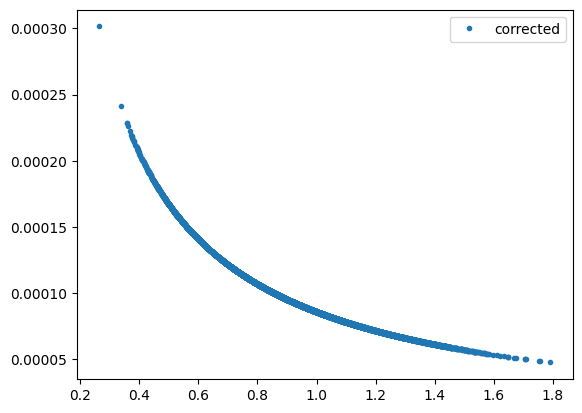

In [74]:
plt.plot(zi, prior_zi_normalized, '.', label='corrected')
plt.legend(loc=1)

### Remove points which have z>10

In [75]:
posteriors_z_list_updated = []
for i in tqdm(range(len(posteriors_z_list))):
    if np.median(posteriors_z_list[i]['redshift']) >=10:
        print(f'Skipping event {i}')
    else:
        posteriors_z_list_updated.append(posteriors_z_list[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3937.45it/s]


In [76]:
len(posteriors_z_list)

2000

In [77]:
len(posteriors_z_list_updated)

2000

### Save to pickle file

In [78]:
num_events

3357

In [79]:
len(posteriors_z_list_updated)

2000

In [80]:
# commented out to avoid accidental overwriting
#pd.to_pickle(posteriors_z_list, os.path.join(base_dir, 'gwpopulation', 'BBH', 'posteriors_from_GWFish', 'mass_bands',
#                        f'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_z_posteriors_10K_{len(posteriors_z_list_updated)}_events_pop_from_XPHM2_{mass_band}.pkl'))
pd.to_pickle(posteriors_z_list, os.path.join(base_dir, 'gwpopulation', 'BBH', 'posteriors_from_GWFish', 'mass_bands',
                        f'LHI_Asharp_2_PLP_z_fref_10_MD_zmax_10_lmrd_22_no_spins_z_posteriors_10K_{len(posteriors_z_list_updated)}_events_pop_from_XPHM2_{mass_band}.pkl'))